In [17]:
# K-means Clustering con Variables Numéricas - Ejercicio 4
# Proyecto Integrador: Análisis de Desigualdades Laborales con Ponderación Poblacional

# NOTAS: Este notebook implementa el ejercicio 4 de K-means clustering usando solo variables numéricas
# del dataset Adult Income, alineado con el nuevo contexto de análisis de desigualdades laborales.
# Se usa capital_neto (capital_gain - capital_loss) para mantener coherencia con el enfoque del estudio.

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Librerías para clustering y evaluación
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples

# Configurar estilo de visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Configurar semilla aleatoria para reproducibilidad
np.random.seed(42)

# Definir nombres de columnas del dataset Adult Census
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

print("✅ SECCIÓN 1: CONFIGURACIÓN INICIAL COMPLETADA")
print("="*60)
print("Librerías importadas correctamente")
print("Semilla aleatoria configurada en 42 para reproducibilidad")
print("Variables numéricas objetivo: age, education_num, capital_neto, hours_per_week")
print("Métricas de evaluación: Silhouette Score y Davies-Bouldin Index")
print("Feature engineering: capital_neto = capital_gain - capital_loss")


✅ SECCIÓN 1: CONFIGURACIÓN INICIAL COMPLETADA
Librerías importadas correctamente
Semilla aleatoria configurada en 42 para reproducibilidad
Variables numéricas objetivo: age, education_num, capital_neto, hours_per_week
Métricas de evaluación: Silhouette Score y Davies-Bouldin Index
Feature engineering: capital_neto = capital_gain - capital_loss


In [18]:
# SECCIÓN 2: CARGA Y LIMPIEZA DE DATOS
# =====================================

# NOTAS: Esta sección carga el dataset Adult Census, realiza limpieza básica
# y crea la variable income_binary para análisis posterior.

print("SECCIÓN 2: CARGA Y LIMPIEZA DE DATOS")
print("="*50)

# Cargar dataset Adult Census
print("Cargando dataset Adult Census...")
df = pd.read_csv('../../../datos/adult.data', names=column_names, na_values=' ?')

print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")

# Información básica del dataset
print(f"\nInformación del dataset:")
print(f"  Columnas: {list(df.columns)}")
print(f"  Tipos de datos:")
for col in df.columns:
    print(f"    {col}: {df[col].dtype}")

# Verificar valores faltantes
print(f"\nValores faltantes por columna:")
missing_values = df.isnull().sum()
for col, missing in missing_values.items():
    if missing > 0:
        print(f"  {col}: {missing} ({missing/len(df)*100:.1f}%)")

# Limpieza básica
print(f"\nRealizando limpieza básica...")

# Eliminar registros con valores faltantes
df_clean = df.dropna().copy()
print(f"  Registros después de eliminar faltantes: {len(df_clean)}")

# Eliminar duplicados
df_clean = df_clean.drop_duplicates().copy()
print(f"  Registros después de eliminar duplicados: {len(df_clean)}")

# Crear variable income_binary (1 para >50K, 0 para <=50K)
df_clean['income_binary'] = (df_clean['income'] == ' >50K').astype(int)

print(f"\nDistribución de income:")
income_dist = df_clean['income'].value_counts()
for income, count in income_dist.items():
    print(f"  {income}: {count} ({count/len(df_clean)*100:.1f}%)")

print(f"\nDistribución de income_binary:")
income_binary_dist = df_clean['income_binary'].value_counts()
for binary, count in income_binary_dist.items():
    print(f"  {binary}: {count} ({count/len(df_clean)*100:.1f}%)")

# Verificar variables numéricas objetivo
numerical_vars = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
print(f"\nVariables numéricas objetivo:")
for var in numerical_vars:
    print(f"  {var}: {df_clean[var].dtype}, rango [{df_clean[var].min()}, {df_clean[var].max()}]")

print("\n✅ SECCIÓN 2: CARGA Y LIMPIEZA COMPLETADA")
print("="*60)
print("Dataset cargado y limpiado")
print("Variable income_binary creada")
print("Variables numéricas verificadas")
print("Datos listos para exploración")


SECCIÓN 2: CARGA Y LIMPIEZA DE DATOS
Cargando dataset Adult Census...
Dataset cargado: 32561 registros, 15 columnas

Información del dataset:
  Columnas: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
  Tipos de datos:
    age: int64
    workclass: object
    fnlwgt: int64
    education: object
    education_num: int64
    marital_status: object
    occupation: object
    relationship: object
    race: object
    sex: object
    capital_gain: int64
    capital_loss: int64
    hours_per_week: int64
    native_country: object
    income: object

Valores faltantes por columna:
  workclass: 1836 (5.6%)
  occupation: 1843 (5.7%)
  native_country: 583 (1.8%)

Realizando limpieza básica...
  Registros después de eliminar faltantes: 30162
  Registros después de eliminar duplicados: 30139

Distribución de income:
   <=50K: 22633 (75.1%)
   >5

SECCIÓN 3: EXPLORACIÓN DE VARIABLES NUMÉRICAS
Variables numéricas a analizar: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Nota: capital_gain y capital_loss se usarán para crear capital_neto

ESTADÍSTICAS DESCRIPTIVAS:
----------------------------------------
            age  education_num  capital_gain  capital_loss  hours_per_week
count  30139.00       30139.00      30139.00      30139.00        30139.00
mean      38.44          10.12       1092.84         88.44           40.93
std       13.13           2.55       7409.11        404.45           11.98
min       17.00           1.00          0.00          0.00            1.00
25%       28.00           9.00          0.00          0.00           40.00
50%       37.00          10.00          0.00          0.00           40.00
75%       47.00          13.00          0.00          0.00           45.00
max       90.00          16.00      99999.00       4356.00           99.00

ANÁLISIS DE DISTRIBUCIONES:
------

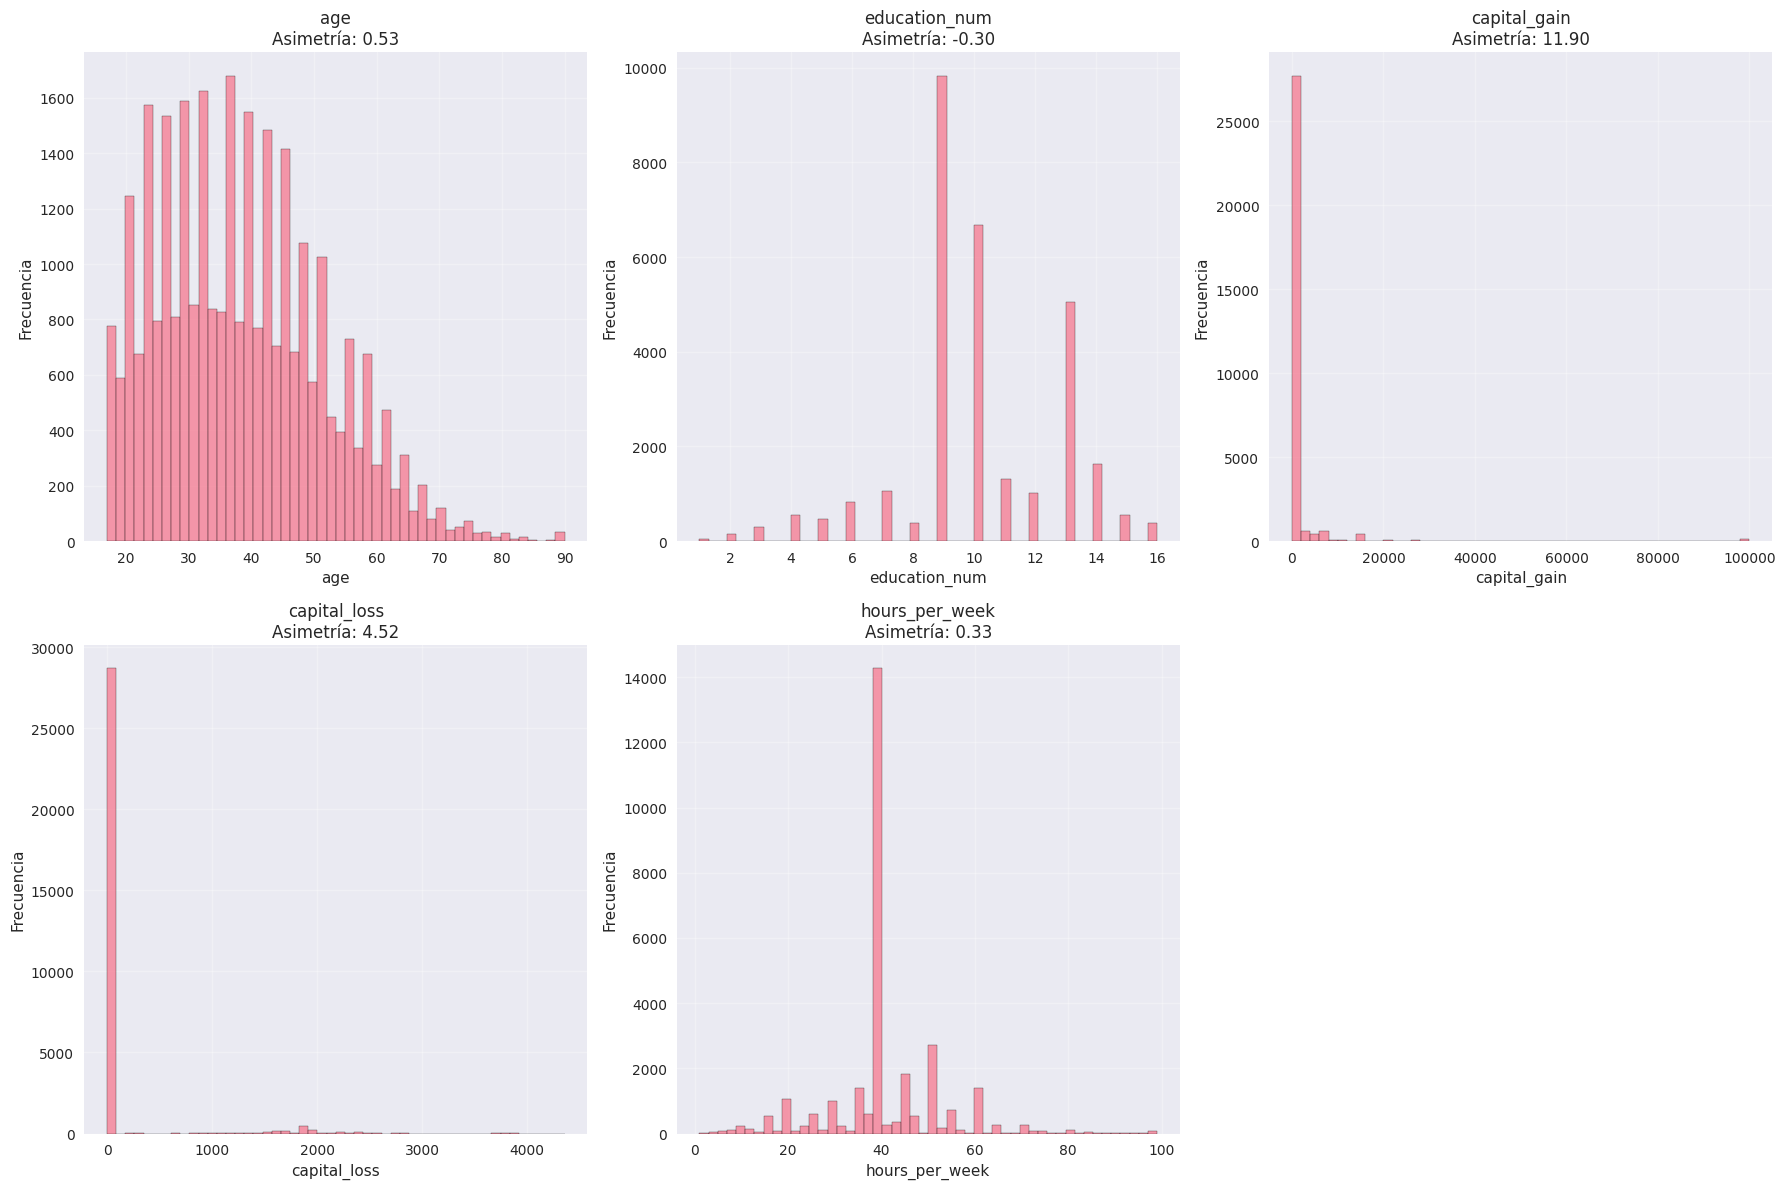


ANÁLISIS DE OUTLIERS:
----------------------------------------
age:
  Límites: [-0.5, 75.5]
  Outliers: 168 (0.6%)
education_num:
  Límites: [3.0, 19.0]
  Outliers: 193 (0.6%)
capital_gain:
  Límites: [0.0, 0.0]
  Outliers: 2538 (8.4%)
capital_loss:
  Límites: [0.0, 0.0]
  Outliers: 1427 (4.7%)
hours_per_week:
  Límites: [32.5, 52.5]
  Outliers: 7947 (26.4%)

MATRIZ DE CORRELACIONES:
----------------------------------------
                  age  education_num  capital_gain  capital_loss  \
age             1.000          0.043         0.080         0.060   
education_num   0.043          1.000         0.124         0.080   
capital_gain    0.080          0.124         1.000        -0.032   
capital_loss    0.060          0.080        -0.032         1.000   
hours_per_week  0.101          0.153         0.080         0.052   

                hours_per_week  
age                      0.101  
education_num            0.153  
capital_gain             0.080  
capital_loss             0.052

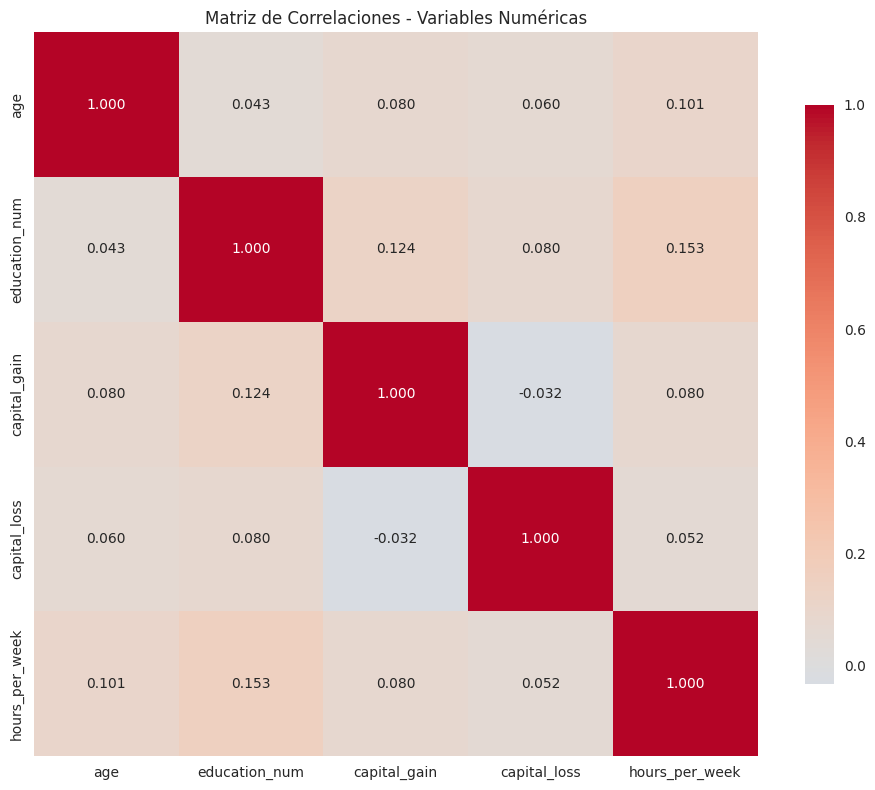


CORRELACIONES CON INCOME_BINARY:
----------------------------------------
Correlación con income_binary:
  age: 0.242
  education_num: 0.335
  capital_gain: 0.221
  capital_loss: 0.150
  hours_per_week: 0.229


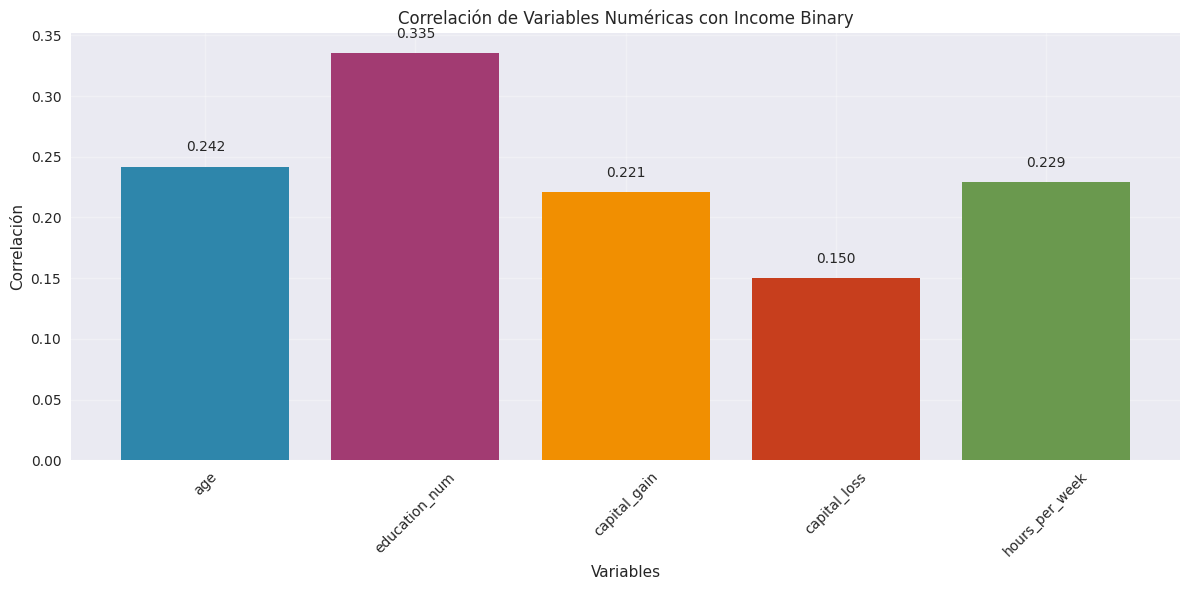


✅ SECCIÓN 3: EXPLORACIÓN COMPLETADA
Estadísticas descriptivas calculadas
Distribuciones analizadas y visualizadas
Outliers identificados
Correlaciones calculadas
Datos listos para feature engineering


In [19]:
# SECCIÓN 3: EXPLORACIÓN DE VARIABLES NUMÉRICAS
# =============================================

# NOTAS: Esta sección explora las 5 variables numéricas objetivo, analiza sus distribuciones,
# detecta outliers y calcula correlaciones para entender las relaciones entre variables.

print("SECCIÓN 3: EXPLORACIÓN DE VARIABLES NUMÉRICAS")
print("="*50)

# Variables numéricas objetivo (incluyendo capital_gain y capital_loss para crear capital_neto)
numerical_vars = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

print(f"Variables numéricas a analizar: {numerical_vars}")
print("Nota: capital_gain y capital_loss se usarán para crear capital_neto")

# Estadísticas descriptivas
print(f"\nESTADÍSTICAS DESCRIPTIVAS:")
print("-" * 40)
desc_stats = df_clean[numerical_vars].describe()
print(desc_stats.round(2))

# Análisis de distribuciones
print(f"\nANÁLISIS DE DISTRIBUCIONES:")
print("-" * 40)

# Crear figura para visualizar distribuciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, var in enumerate(numerical_vars):
    # Estadísticas de forma
    mean_val = df_clean[var].mean()
    std_val = df_clean[var].std()
    skewness = df_clean[var].skew()
    kurtosis = df_clean[var].kurtosis()
    
    print(f"\n{var}:")
    print(f"  Media: {mean_val:.2f}, Desv. Estándar: {std_val:.2f}")
    print(f"  Asimetría: {skewness:.2f}, Curtosis: {kurtosis:.2f}")
    
    # Clasificar distribución
    if abs(skewness) < 0.5:
        dist_type = "Simétrica"
    elif abs(skewness) < 1.0:
        dist_type = "Ligeramente sesgada"
    else:
        dist_type = "Muy sesgada"
    
    print(f"  Tipo de distribución: {dist_type}")
    
    # Histograma
    axes[i].hist(df_clean[var], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{var}\nAsimetría: {skewness:.2f}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)

# Ocultar el último subplot si no se usa
if len(numerical_vars) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Análisis de outliers
print(f"\nANÁLISIS DE OUTLIERS:")
print("-" * 40)

for var in numerical_vars:
    Q1 = df_clean[var].quantile(0.25)
    Q3 = df_clean[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean[var] < lower_bound) | (df_clean[var] > upper_bound)]
    outlier_pct = len(outliers) / len(df_clean) * 100
    
    print(f"{var}:")
    print(f"  Límites: [{lower_bound:.1f}, {upper_bound:.1f}]")
    print(f"  Outliers: {len(outliers)} ({outlier_pct:.1f}%)")

# Matriz de correlaciones
print(f"\nMATRIZ DE CORRELACIONES:")
print("-" * 40)

correlation_matrix = df_clean[numerical_vars].corr()
print(correlation_matrix.round(3))

# Visualizar matriz de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlaciones - Variables Numéricas')
plt.tight_layout()
plt.show()

# Análisis de correlaciones con income_binary
print(f"\nCORRELACIONES CON INCOME_BINARY:")
print("-" * 40)

income_correlations = df_clean[numerical_vars + ['income_binary']].corr()['income_binary'].drop('income_binary')
print("Correlación con income_binary:")
for var, corr in income_correlations.items():
    print(f"  {var}: {corr:.3f}")

# Visualizar correlaciones con income
plt.figure(figsize=(12, 6))
bars = plt.bar(numerical_vars, income_correlations.values, 
               color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E'])
plt.title('Correlación de Variables Numéricas con Income Binary')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, corr in zip(bars, income_correlations.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{corr:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n✅ SECCIÓN 3: EXPLORACIÓN COMPLETADA")
print("="*60)
print("Estadísticas descriptivas calculadas")
print("Distribuciones analizadas y visualizadas")
print("Outliers identificados")
print("Correlaciones calculadas")
print("Datos listos para feature engineering")


SECCIÓN 4: FEATURE ENGINEERING - CAPITAL_NETO
Creando variable capital_neto...
Variable capital_neto creada: capital_gain - capital_loss

ANÁLISIS DE CAPITAL_NETO:
----------------------------------------
Estadísticas de capital_neto:
count    30139.00
mean      1004.40
std       7433.16
min      -4356.00
25%          0.00
50%          0.00
75%          0.00
max      99999.00
Name: capital_neto, dtype: float64

Distribución de capital_neto:
Top 10 valores más frecuentes:
  0: 26174 (86.8%)
  15024: 337 (1.1%)
  7688: 270 (0.9%)
  7298: 240 (0.8%)
  -1902: 194 (0.6%)
  -1977: 162 (0.5%)
  -1887: 155 (0.5%)
  99999: 148 (0.5%)
  3103: 94 (0.3%)
  5178: 91 (0.3%)

CASOS ESPECIALES:
----------------------------------------
Casos con capital_gain > 0 Y capital_loss > 0: 0 (0.0%)
Casos con capital_neto < 0: 1427 (4.7%)
Casos con capital_neto = 0: 26174 (86.8%)

Creando visualizaciones comparativas...


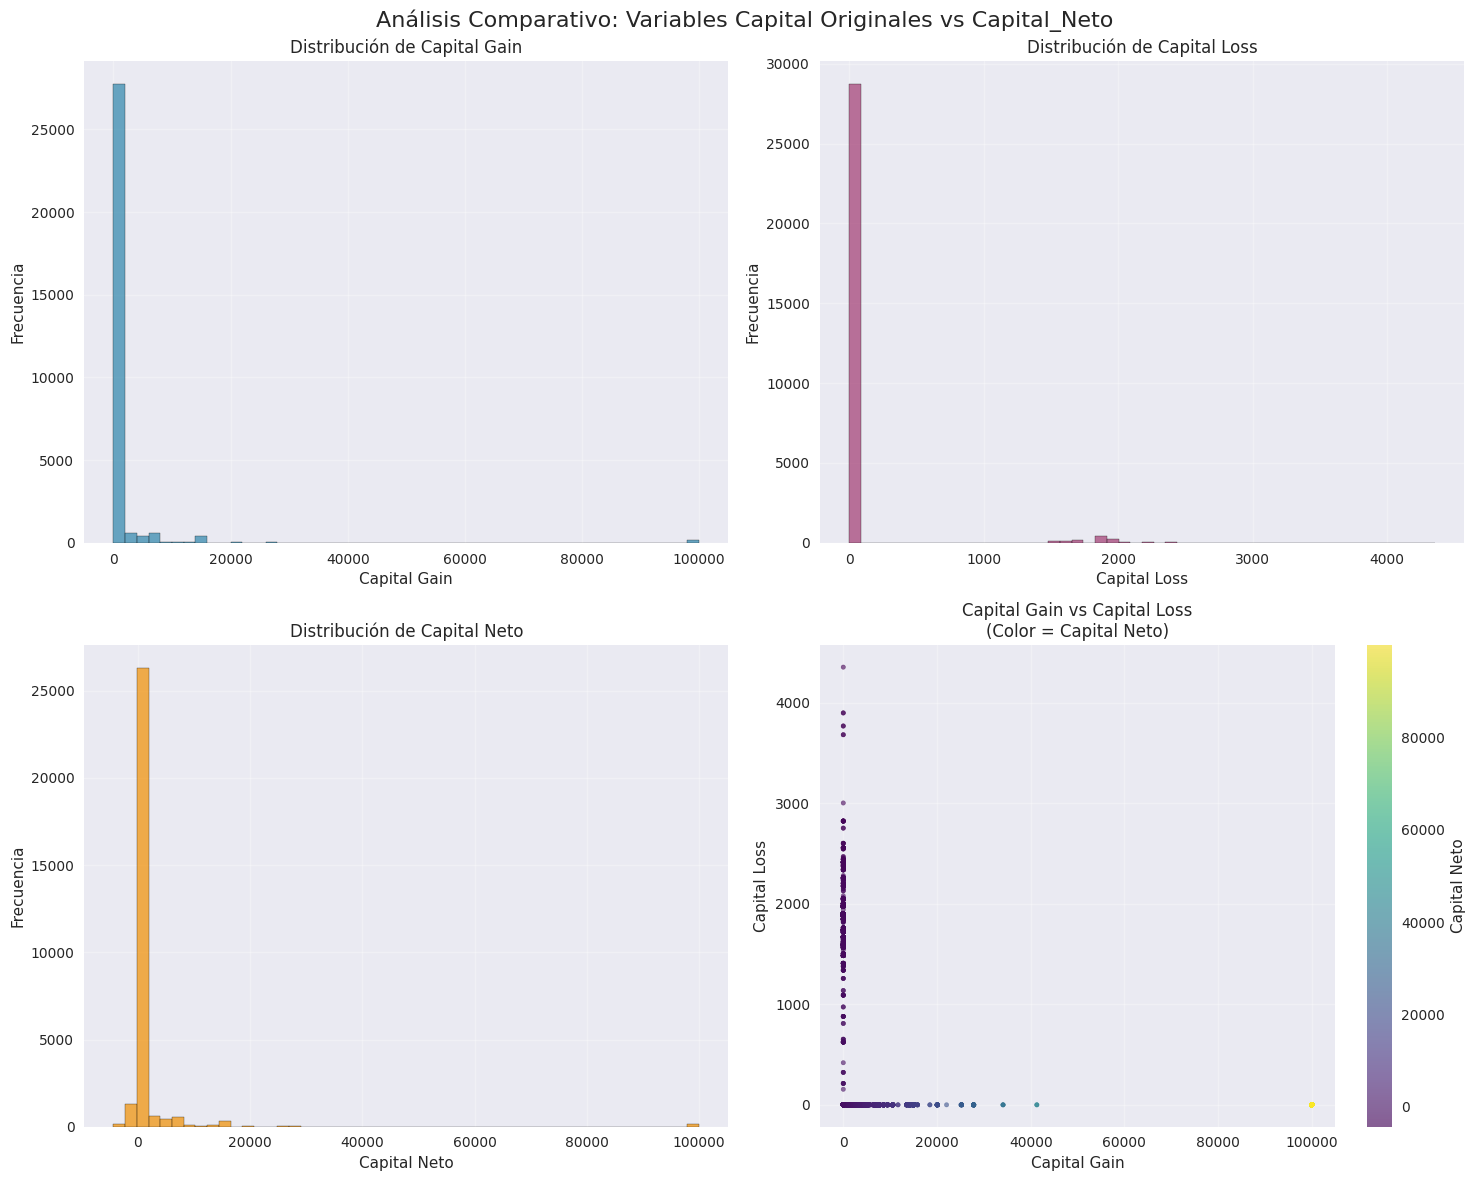


ANÁLISIS DE CORRELACIONES:
----------------------------------------
Correlación con income_binary:
  capital_gain: 0.221
  capital_loss: 0.150
  capital_neto: 0.212

Correlaciones entre variables capital:
              capital_gain  capital_loss  capital_neto
capital_gain         1.000        -0.032         0.999
capital_loss        -0.032         1.000        -0.087
capital_neto         0.999        -0.087         1.000

VARIABLES FINALES PARA K-MEANS:
----------------------------------------
Variables finales (4 variables): ['age', 'education_num', 'capital_neto', 'hours_per_week']
Variables eliminadas: capital_gain, capital_loss
Variable creada: capital_neto = capital_gain - capital_loss

JUSTIFICACIÓN DE LA DECISIÓN:
----------------------------------------
✅ VENTAJAS DE USAR CAPITAL_NETO:
  - Coherencia con el enfoque del estudio
  - Variable más interpretable (ganancia neta)
  - Reduce dimensionalidad (4 vs 5 variables)
  - Elimina redundancia entre gain y loss
  - Facilita comp

In [20]:
# SECCIÓN 4: FEATURE ENGINEERING - CAPITAL_NETO
# ==============================================

# NOTAS: Esta sección crea la variable capital_neto = capital_gain - capital_loss
# para mantener coherencia con el enfoque del estudio. Se eliminan capital_gain y capital_loss
# individuales y se usa capital_neto como variable única.

print("SECCIÓN 4: FEATURE ENGINEERING - CAPITAL_NETO")
print("="*50)

# Crear variable capital_neto
print("Creando variable capital_neto...")
df_clean['capital_neto'] = df_clean['capital_gain'] - df_clean['capital_loss']

print(f"Variable capital_neto creada: capital_gain - capital_loss")

# Análisis de capital_neto
print(f"\nANÁLISIS DE CAPITAL_NETO:")
print("-" * 40)

capital_neto_stats = df_clean['capital_neto'].describe()
print("Estadísticas de capital_neto:")
print(capital_neto_stats.round(2))

# Distribución de capital_neto
print(f"\nDistribución de capital_neto:")
capital_neto_dist = df_clean['capital_neto'].value_counts().head(10)
print("Top 10 valores más frecuentes:")
for value, count in capital_neto_dist.items():
    print(f"  {value}: {count} ({count/len(df_clean)*100:.1f}%)")

# Análisis de casos especiales
print(f"\nCASOS ESPECIALES:")
print("-" * 40)

# Casos con capital_gain > 0 y capital_loss > 0
both_positive = df_clean[(df_clean['capital_gain'] > 0) & (df_clean['capital_loss'] > 0)]
print(f"Casos con capital_gain > 0 Y capital_loss > 0: {len(both_positive)} ({len(both_positive)/len(df_clean)*100:.1f}%)")

# Casos con capital_neto negativo
negative_neto = df_clean[df_clean['capital_neto'] < 0]
print(f"Casos con capital_neto < 0: {len(negative_neto)} ({len(negative_neto)/len(df_clean)*100:.1f}%)")

# Casos con capital_neto = 0
zero_neto = df_clean[df_clean['capital_neto'] == 0]
print(f"Casos con capital_neto = 0: {len(zero_neto)} ({len(zero_neto)/len(df_clean)*100:.1f}%)")

# Visualizar distribuciones comparativas
print(f"\nCreando visualizaciones comparativas...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis Comparativo: Variables Capital Originales vs Capital_Neto', fontsize=16)

# 1. Distribución de capital_gain
axes[0, 0].hist(df_clean['capital_gain'], bins=50, alpha=0.7, color='#2E86AB', edgecolor='black')
axes[0, 0].set_title('Distribución de Capital Gain')
axes[0, 0].set_xlabel('Capital Gain')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución de capital_loss
axes[0, 1].hist(df_clean['capital_loss'], bins=50, alpha=0.7, color='#A23B72', edgecolor='black')
axes[0, 1].set_title('Distribución de Capital Loss')
axes[0, 1].set_xlabel('Capital Loss')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribución de capital_neto
axes[1, 0].hist(df_clean['capital_neto'], bins=50, alpha=0.7, color='#F18F01', edgecolor='black')
axes[1, 0].set_title('Distribución de Capital Neto')
axes[1, 0].set_xlabel('Capital Neto')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter plot: capital_gain vs capital_loss
scatter = axes[1, 1].scatter(df_clean['capital_gain'], df_clean['capital_loss'], 
                            c=df_clean['capital_neto'], cmap='viridis', alpha=0.6, s=10)
axes[1, 1].set_title('Capital Gain vs Capital Loss\n(Color = Capital Neto)')
axes[1, 1].set_xlabel('Capital Gain')
axes[1, 1].set_ylabel('Capital Loss')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Capital Neto')

plt.tight_layout()
plt.show()

# Análisis de correlaciones
print(f"\nANÁLISIS DE CORRELACIONES:")
print("-" * 40)

# Correlaciones con income_binary
correlations_with_income = df_clean[['capital_gain', 'capital_loss', 'capital_neto', 'income_binary']].corr()['income_binary'].drop('income_binary')
print("Correlación con income_binary:")
for var, corr in correlations_with_income.items():
    print(f"  {var}: {corr:.3f}")

# Correlaciones entre variables capital
capital_correlations = df_clean[['capital_gain', 'capital_loss', 'capital_neto']].corr()
print(f"\nCorrelaciones entre variables capital:")
print(capital_correlations.round(3))

# Definir variables finales para K-means
print(f"\nVARIABLES FINALES PARA K-MEANS:")
print("-" * 40)

# Variables finales: eliminar capital_gain y capital_loss, usar capital_neto
final_vars = ['age', 'education_num', 'capital_neto', 'hours_per_week']

print(f"Variables finales (4 variables): {final_vars}")
print("Variables eliminadas: capital_gain, capital_loss")
print("Variable creada: capital_neto = capital_gain - capital_loss")

# Justificación de la decisión
print(f"\nJUSTIFICACIÓN DE LA DECISIÓN:")
print("-" * 40)

print("✅ VENTAJAS DE USAR CAPITAL_NETO:")
print("  - Coherencia con el enfoque del estudio")
print("  - Variable más interpretable (ganancia neta)")
print("  - Reduce dimensionalidad (4 vs 5 variables)")
print("  - Elimina redundancia entre gain y loss")
print("  - Facilita comparación con análisis de Gower")
print("  - Mantiene la información esencial sobre capital")

print(f"\n📊 IMPACTO EN EL ANÁLISIS:")
print("  - K-means será más eficiente con 4 variables")
print("  - Mejor interpretabilidad de clusters")
print("  - Coherencia metodológica con el resto del estudio")
print("  - Facilita análisis demográfico posterior")

print("\n✅ SECCIÓN 4: FEATURE ENGINEERING COMPLETADA")
print("="*60)
print("Variable capital_neto creada y analizada")
print("Variables finales definidas: age, education_num, capital_neto, hours_per_week")
print("Coherencia con enfoque del estudio establecida")
print("Datos listos para normalización")


SECCIÓN 5: NORMALIZACIÓN DE VARIABLES
Variables finales: ['age', 'education_num', 'capital_neto', 'hours_per_week']

ANÁLISIS DE DISTRIBUCIONES PARA NORMALIZACIÓN:
--------------------------------------------------
Variables para StandardScaler: ['age', 'hours_per_week']
Variables para MinMaxScaler: ['education_num', 'capital_neto']

Preparando datos para normalización...
Dataset final: (30139, 4)

Aplicando normalización...
Normalización aplicada:
  StandardScaler: ['age', 'hours_per_week']
  MinMaxScaler: ['education_num', 'capital_neto']

VERIFICACIÓN DE NORMALIZACIÓN:
--------------------------------------------------
  age (StandardScaler): [-1.633, 3.926], media=0.000, std=1.000
  education_num (MinMaxScaler): [0.000, 1.000], media=0.608, std=0.170
  capital_neto (MinMaxScaler): [0.000, 1.000], media=0.051, std=0.071
  hours_per_week (StandardScaler): [-3.334, 4.847], media=-0.000, std=1.000

Creando visualizaciones de distribuciones normalizadas...


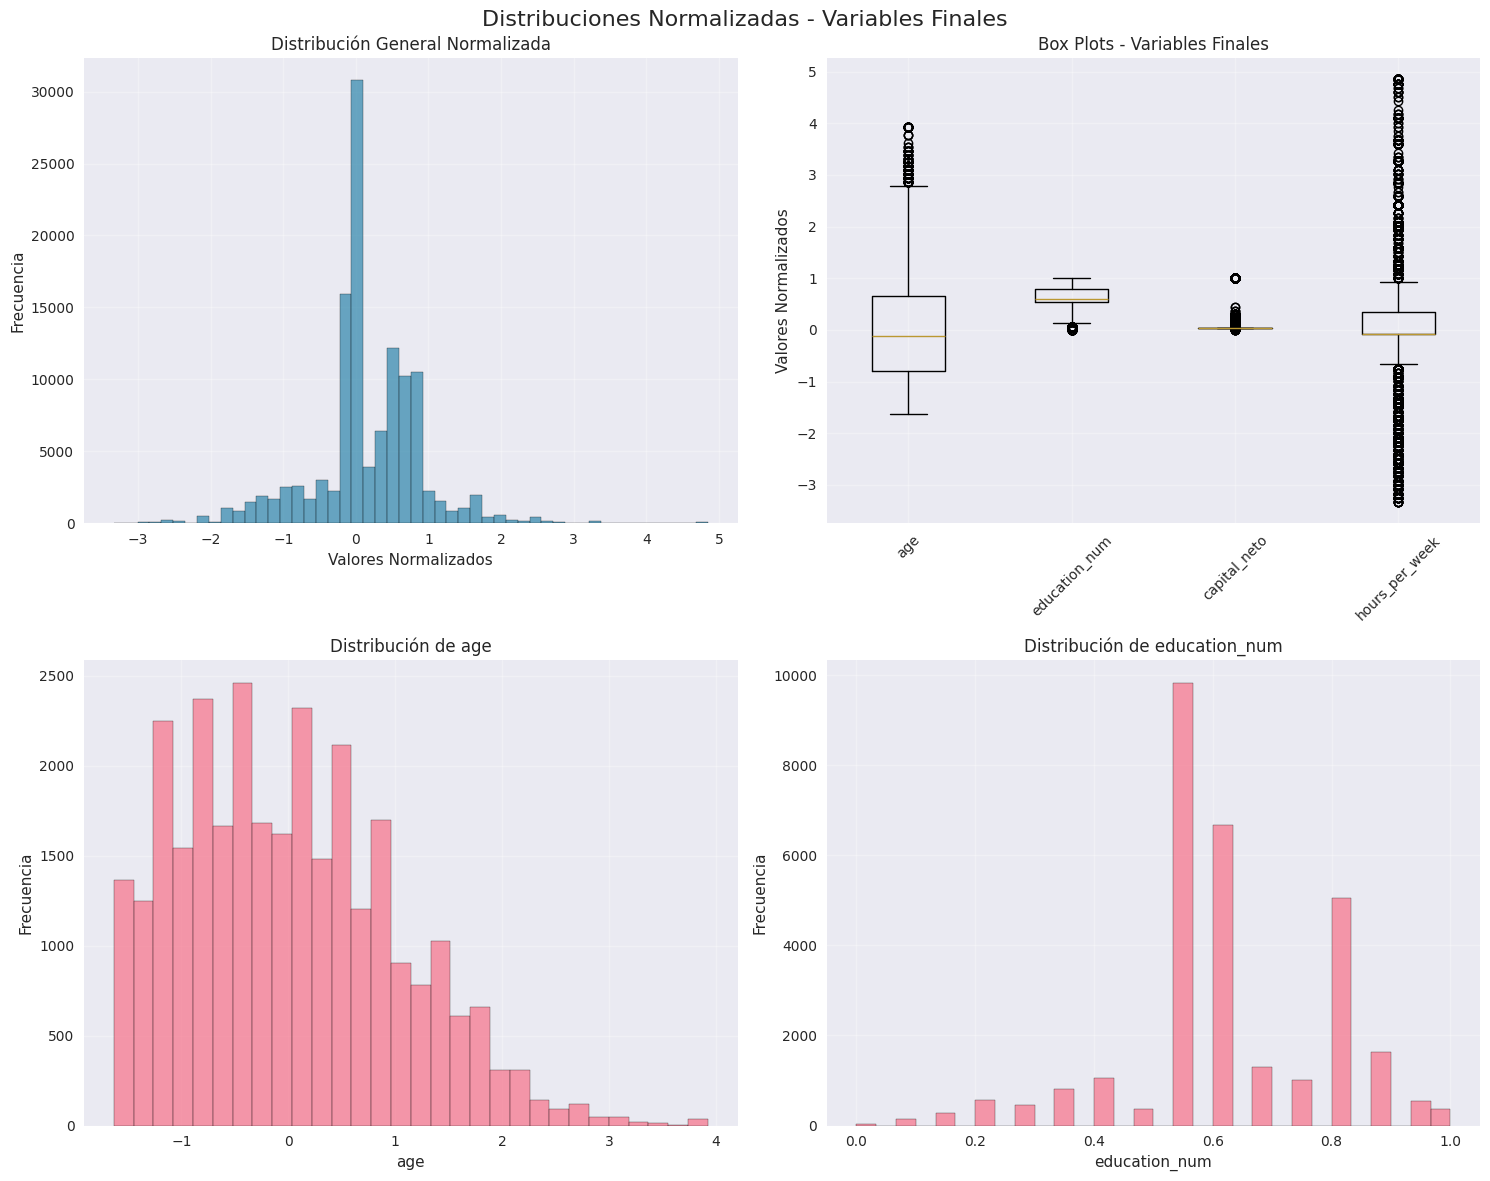


Verificando valores faltantes:
  Dataset final: 0 valores faltantes

Verificando valores infinitos:
  Dataset final: 0 valores infinitos

✅ SECCIÓN 5: NORMALIZACIÓN COMPLETADA
Variables finales normalizadas
StandardScaler aplicado a variables con distribución normal
MinMaxScaler aplicado a variables sesgadas
Distribuciones verificadas y visualizadas
Datos listos para creación de muestras


In [21]:
# SECCIÓN 5: NORMALIZACIÓN DE VARIABLES
# =====================================

# NOTAS: Esta sección normaliza las variables finales usando
# StandardScaler para variables con distribución normal y MinMaxScaler para variables sesgadas.
# Se preparan los datasets normalizados para K-means.

print("SECCIÓN 5: NORMALIZACIÓN DE VARIABLES")
print("="*50)

# Usar variables finales definidas en la sección anterior
print(f"Variables finales: {final_vars}")

# Analizar distribuciones para decidir tipo de normalización
print(f"\nANÁLISIS DE DISTRIBUCIONES PARA NORMALIZACIÓN:")
print("-" * 50)

# Variables para StandardScaler (distribución normal)
standard_vars = ['age', 'hours_per_week']

# Variables para MinMaxScaler (distribución sesgada)
minmax_vars = ['education_num', 'capital_neto']

print(f"Variables para StandardScaler: {standard_vars}")
print(f"Variables para MinMaxScaler: {minmax_vars}")

# Preparar datos para normalización
print(f"\nPreparando datos para normalización...")

# Dataset final con variables seleccionadas
X_final = df_clean[final_vars].copy()
print(f"Dataset final: {X_final.shape}")

# Aplicar normalización
print(f"\nAplicando normalización...")

# StandardScaler para variables con distribución normal
scaler_standard = StandardScaler()
X_final[standard_vars] = scaler_standard.fit_transform(X_final[standard_vars])

# MinMaxScaler para variables sesgadas
scaler_minmax = MinMaxScaler()
X_final[minmax_vars] = scaler_minmax.fit_transform(X_final[minmax_vars])

print(f"Normalización aplicada:")
print(f"  StandardScaler: {standard_vars}")
print(f"  MinMaxScaler: {minmax_vars}")

# Verificar normalización
print(f"\nVERIFICACIÓN DE NORMALIZACIÓN:")
print("-" * 50)

for var in final_vars:
    min_val = X_final[var].min()
    max_val = X_final[var].max()
    mean_val = X_final[var].mean()
    std_val = X_final[var].std()
    
    if var in standard_vars:
        print(f"  {var} (StandardScaler): [{min_val:.3f}, {max_val:.3f}], media={mean_val:.3f}, std={std_val:.3f}")
    else:
        print(f"  {var} (MinMaxScaler): [{min_val:.3f}, {max_val:.3f}], media={mean_val:.3f}, std={std_val:.3f}")

# Visualizar distribuciones normalizadas
print(f"\nCreando visualizaciones de distribuciones normalizadas...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribuciones Normalizadas - Variables Finales', fontsize=16)

# Histograma general
axes[0, 0].hist(X_final.values.flatten(), bins=50, alpha=0.7, color='#2E86AB', edgecolor='black')
axes[0, 0].set_title('Distribución General Normalizada')
axes[0, 0].set_xlabel('Valores Normalizados')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Box plot general
axes[0, 1].boxplot([X_final[var] for var in final_vars], labels=final_vars)
axes[0, 1].set_title('Box Plots - Variables Finales')
axes[0, 1].set_ylabel('Valores Normalizados')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Distribuciones individuales
for i, var in enumerate(final_vars):
    if i < 2:  # Solo mostrar las primeras 2 variables en los subplots restantes
        axes[1, i].hist(X_final[var], bins=30, alpha=0.7, edgecolor='black')
        axes[1, i].set_title(f'Distribución de {var}')
        axes[1, i].set_xlabel(var)
        axes[1, i].set_ylabel('Frecuencia')
        axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Verificar que no hay valores faltantes
print(f"\nVerificando valores faltantes:")
print(f"  Dataset final: {X_final.isnull().sum().sum()} valores faltantes")

# Verificar que no hay valores infinitos
print(f"\nVerificando valores infinitos:")
print(f"  Dataset final: {np.isinf(X_final.values).sum()} valores infinitos")

print("\n✅ SECCIÓN 5: NORMALIZACIÓN COMPLETADA")
print("="*60)
print("Variables finales normalizadas")
print("StandardScaler aplicado a variables con distribución normal")
print("MinMaxScaler aplicado a variables sesgadas")
print("Distribuciones verificadas y visualizadas")
print("Datos listos para creación de muestras")


In [22]:
# SECCIÓN 6: CREACIÓN DE MUESTRAS REPRODUCIBLES
# ==============================================

# NOTAS: Esta sección crea muestras reproducibles de 5,000 y 10,000 registros
# con las variables finales normalizadas, manteniendo los índices para cruce posterior
# con variables categóricas y preservando fnlwgt para análisis interpretativo.

print("SECCIÓN 6: CREACIÓN DE MUESTRAS REPRODUCIBLES")
print("="*50)

# Crear muestras reproducibles
print("Creando muestras reproducibles...")

# Muestra de 5,000 registros
sample_5k = df_clean.sample(n=5000, random_state=42)
print(f"Muestra 5K: {len(sample_5k)} registros")

# Muestra de 10,000 registros  
sample_10k = df_clean.sample(n=10000, random_state=42)
print(f"Muestra 10K: {len(sample_10k)} registros")

# Preparar DataFrames con variables normalizadas para ambas muestras
print(f"\nPreparando DataFrames normalizados...")

# Para muestra 5K
X_5k = sample_5k[final_vars].copy()
# Aplicar normalización a muestra 5K
X_5k[standard_vars] = scaler_standard.transform(sample_5k[standard_vars])
X_5k[minmax_vars] = scaler_minmax.transform(sample_5k[minmax_vars])

# Para muestra 10K
X_10k = sample_10k[final_vars].copy()
# Aplicar normalización a muestra 10K
X_10k[standard_vars] = scaler_standard.transform(sample_10k[standard_vars])
X_10k[minmax_vars] = scaler_minmax.transform(sample_10k[minmax_vars])

print(f"DataFrames normalizados creados:")
print(f"  Muestra 5K: {X_5k.shape}")
print(f"  Muestra 10K: {X_10k.shape}")

# Verificar que no hay valores faltantes
print(f"\nVerificando valores faltantes:")
print(f"  Muestra 5K: {X_5k.isnull().sum().sum()} valores faltantes")
print(f"  Muestra 10K: {X_10k.isnull().sum().sum()} valores faltantes")

# Mostrar distribuciones de variables clave en las muestras
print(f"\nDistribuciones de variables clave (muestra 5K):")
print(f"  Income: {sample_5k['income'].value_counts().to_dict()}")
print(f"  Age range: [{sample_5k['age'].min()}, {sample_5k['age'].max()}]")
print(f"  Education_num range: [{sample_5k['education_num'].min()}, {sample_5k['education_num'].max()}]")
print(f"  Capital_neto range: [{sample_5k['capital_neto'].min()}, {sample_5k['capital_neto'].max()}]")

print(f"\nDistribuciones de variables clave (muestra 10K):")
print(f"  Income: {sample_10k['income'].value_counts().to_dict()}")
print(f"  Age range: [{sample_10k['age'].min()}, {sample_10k['age'].max()}]")
print(f"  Education_num range: [{sample_10k['education_num'].min()}, {sample_10k['education_num'].max()}]")
print(f"  Capital_neto range: [{sample_10k['capital_neto'].min()}, {sample_10k['capital_neto'].max()}]")

# Verificar normalización en las muestras
print(f"\nVerificación de normalización (muestra 5K):")
for var in final_vars:
    min_val = X_5k[var].min()
    max_val = X_5k[var].max()
    mean_val = X_5k[var].mean()
    std_val = X_5k[var].std()
    print(f"  {var}: [{min_val:.3f}, {max_val:.3f}], media={mean_val:.3f}, std={std_val:.3f}")

print(f"\nVerificación de normalización (muestra 10K):")
for var in final_vars:
    min_val = X_10k[var].min()
    max_val = X_10k[var].max()
    mean_val = X_10k[var].mean()
    std_val = X_10k[var].std()
    print(f"  {var}: [{min_val:.3f}, {max_val:.3f}], media={mean_val:.3f}, std={std_val:.3f}")

# Verificar que fnlwgt se preserva para análisis interpretativo
print(f"\nVerificando preservación de fnlwgt:")
print(f"  Muestra 5K - fnlwgt range: [{sample_5k['fnlwgt'].min()}, {sample_5k['fnlwgt'].max()}]")
print(f"  Muestra 10K - fnlwgt range: [{sample_10k['fnlwgt'].min()}, {sample_10k['fnlwgt'].max()}]")

# Verificar que las muestras mantienen las proporciones de income
print(f"\nVerificando proporciones de income:")
income_5k_pct = sample_5k['income_binary'].mean() * 100
income_10k_pct = sample_10k['income_binary'].mean() * 100
income_full_pct = df_clean['income_binary'].mean() * 100

print(f"  Dataset completo: {income_full_pct:.1f}% con income >50K")
print(f"  Muestra 5K: {income_5k_pct:.1f}% con income >50K")
print(f"  Muestra 10K: {income_10k_pct:.1f}% con income >50K")

print("\n✅ SECCIÓN 6: CREACIÓN DE MUESTRAS COMPLETADA")
print("="*60)
print("Muestras reproducibles creadas (5K y 10K)")
print("Variables finales normalizadas aplicadas")
print("Distribuciones verificadas")
print("fnlwgt preservado para análisis interpretativo")
print("Datos listos para clustering K-means")


SECCIÓN 6: CREACIÓN DE MUESTRAS REPRODUCIBLES
Creando muestras reproducibles...
Muestra 5K: 5000 registros
Muestra 10K: 10000 registros

Preparando DataFrames normalizados...
DataFrames normalizados creados:
  Muestra 5K: (5000, 4)
  Muestra 10K: (10000, 4)

Verificando valores faltantes:
  Muestra 5K: 0 valores faltantes
  Muestra 10K: 0 valores faltantes

Distribuciones de variables clave (muestra 5K):
  Income: {' <=50K': 3718, ' >50K': 1282}
  Age range: [17, 90]
  Education_num range: [1, 16]
  Capital_neto range: [-3900, 99999]

Distribuciones de variables clave (muestra 10K):
  Income: {' <=50K': 7466, ' >50K': 2534}
  Age range: [17, 90]
  Education_num range: [1, 16]
  Capital_neto range: [-4356, 99999]

Verificación de normalización (muestra 5K):
  age: [-1.633, 3.926], media=-0.017, std=0.981
  education_num: [0.000, 1.000], media=0.608, std=0.168
  capital_neto: [0.004, 1.000], media=0.053, std=0.079
  hours_per_week: [-3.334, 4.847], media=0.008, std=1.003

Verificación de

SECCIÓN 7: K-MEANS CON VARIABLES FINALES - MUESTRA 5K
Probando valores de k: [2, 3, 4, 5, 6, 7, 8, 9, 10]

Aplicando K-means a muestra 5K...
Probando k=2...
  Silhouette: 0.3517, Davies-Bouldin: 1.1138, Tiempo: 0.34s
Probando k=3...
  Silhouette: 0.3864, Davies-Bouldin: 0.9133, Tiempo: 0.13s
Probando k=4...
  Silhouette: 0.4033, Davies-Bouldin: 0.8262, Tiempo: 0.14s
Probando k=5...
  Silhouette: 0.4189, Davies-Bouldin: 0.7633, Tiempo: 0.16s
Probando k=6...
  Silhouette: 0.3695, Davies-Bouldin: 0.8214, Tiempo: 0.22s
Probando k=7...
  Silhouette: 0.3772, Davies-Bouldin: 0.8381, Tiempo: 0.30s
Probando k=8...
  Silhouette: 0.3910, Davies-Bouldin: 0.7880, Tiempo: 0.28s
Probando k=9...
  Silhouette: 0.3558, Davies-Bouldin: 0.8141, Tiempo: 0.31s
Probando k=10...
  Silhouette: 0.3590, Davies-Bouldin: 0.8029, Tiempo: 0.29s

K óptimo según Silhouette: 5 (score: 0.4189)
K óptimo según Davies-Bouldin: 5 (score: 0.7633)

Creando visualizaciones...


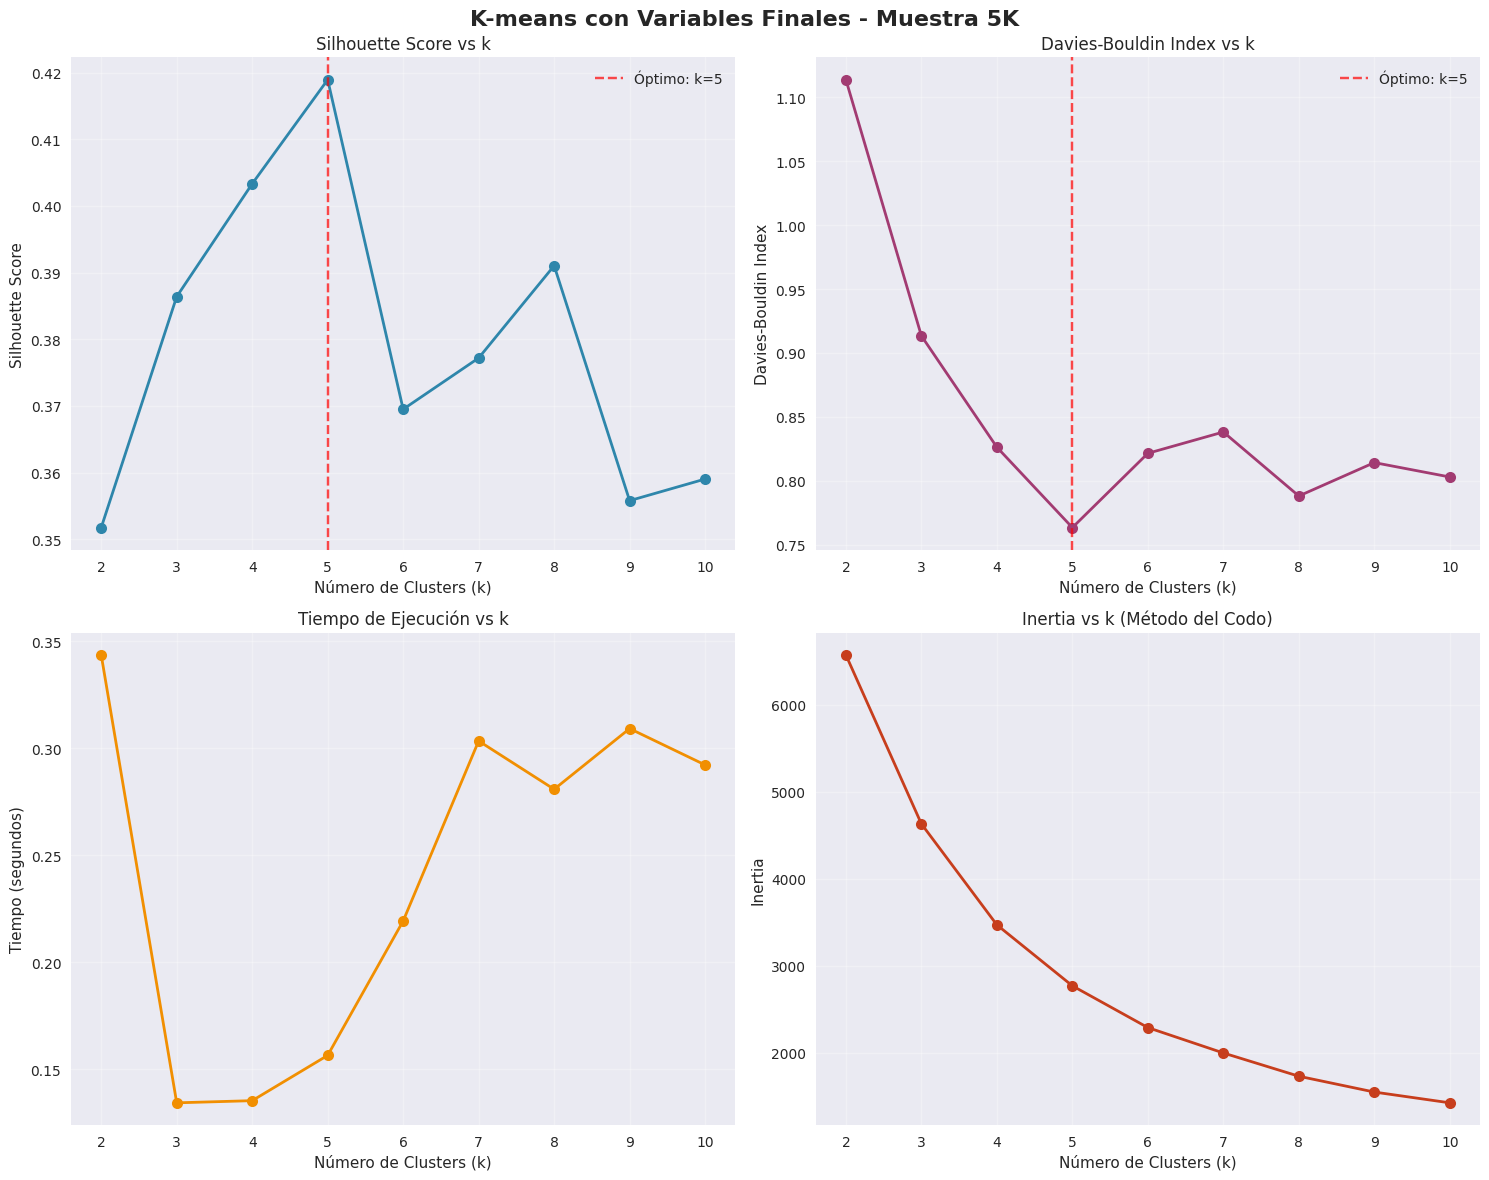


Creando scatter plot de clusters (k óptimo = 5)...


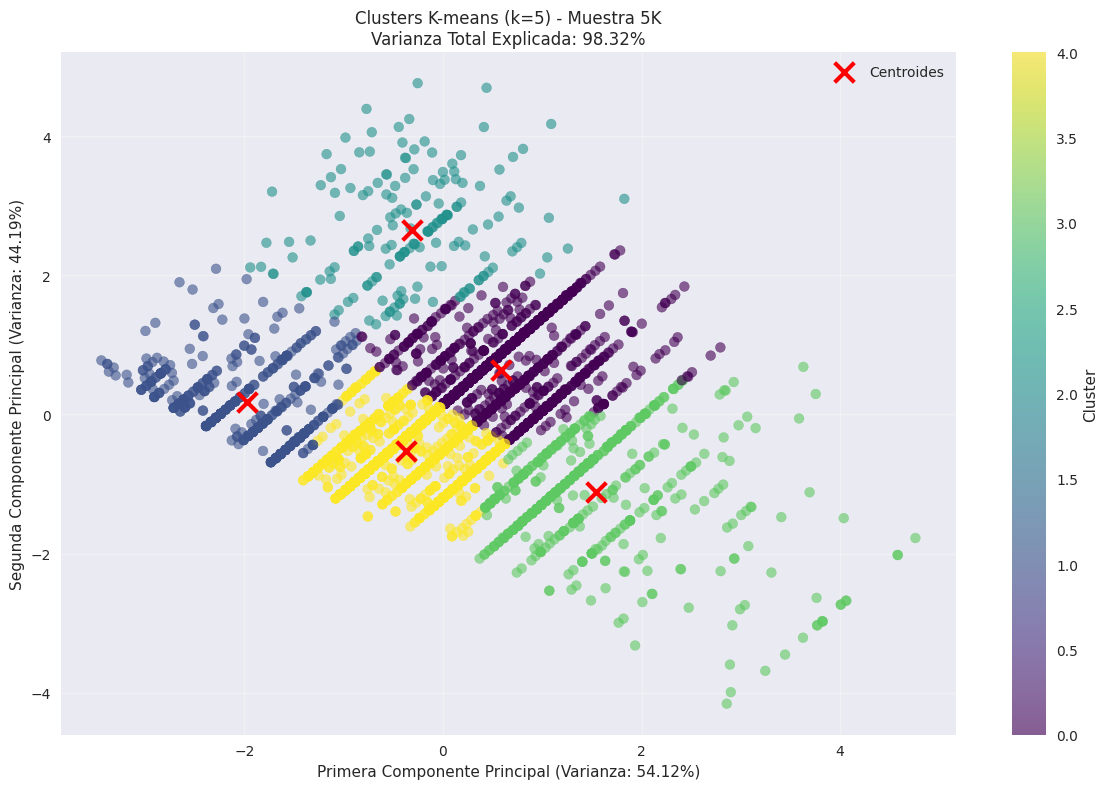


ANÁLISIS DE PATRONES EN CLUSTERS (k=5):
--------------------------------------------------

Cluster 0 (1739 registros):
  Edad promedio: 49.6
  Educación promedio: 10.2
  Horas/semana promedio: 41.8
  Capital neto promedio: 1515.1
  DISTRIBUCIÓN DE INGRESOS:
    <=50K: 1056 registros (60.7%)
    >50K:  683 registros (39.3%)

Cluster 1 (501 registros):
  Edad promedio: 23.8
  Educación promedio: 9.6
  Horas/semana promedio: 21.3
  Capital neto promedio: 182.5
  DISTRIBUCIÓN DE INGRESOS:
    <=50K: 485 registros (96.8%)
    >50K:  16 registros (3.2%)

Cluster 2 (172 registros):
  Edad promedio: 62.9
  Educación promedio: 9.4
  Horas/semana promedio: 18.3
  Capital neto promedio: 576.7
  DISTRIBUCIÓN DE INGRESOS:
    <=50K: 148 registros (86.0%)
    >50K:  24 registros (14.0%)

Cluster 3 (519 registros):
  Edad promedio: 39.4
  Educación promedio: 11.0
  Horas/semana promedio: 63.8
  Capital neto promedio: 3108.3
  DISTRIBUCIÓN DE INGRESOS:
    <=50K: 291 registros (56.1%)
    >50K:  228

In [23]:
# SECCIÓN 7: K-MEANS CON VARIABLES FINALES - MUESTRA 5K
# =====================================================

# NOTAS: Esta sección aplica K-means con las variables finales (age, education_num, capital_neto, hours_per_week)
# a la muestra de 5,000 registros. Se prueban valores de k de 2 a 10, se calculan
# Silhouette Score y Davies-Bouldin Index, y se crean visualizaciones.

print("SECCIÓN 7: K-MEANS CON VARIABLES FINALES - MUESTRA 5K")
print("="*60)

# Definir rango de k a probar
k_values = list(range(2, 11))  # k=2 hasta k=10
print(f"Probando valores de k: {k_values}")

# Almacenar resultados para Muestra 5K
results_5k = {
    'k_values': k_values,
    'silhouette_scores': [],
    'davies_bouldin_scores': [],
    'execution_times': [],
    'cluster_labels': [],
    'inertias': []
}

print(f"\nAplicando K-means a muestra 5K...")
print("="*50)

for k in k_values:
    print(f"Probando k={k}...")
    
    # Medir tiempo de ejecución
    start_time = time.time()
    
    # Aplicar K-means
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    
    labels = kmeans.fit_predict(X_5k)
    execution_time = time.time() - start_time
    
    # Calcular métricas
    silhouette = silhouette_score(X_5k, labels)
    davies_bouldin = davies_bouldin_score(X_5k, labels)
    inertia = kmeans.inertia_
    
    # Almacenar resultados
    results_5k['silhouette_scores'].append(silhouette)
    results_5k['davies_bouldin_scores'].append(davies_bouldin)
    results_5k['execution_times'].append(execution_time)
    results_5k['cluster_labels'].append(labels)
    results_5k['inertias'].append(inertia)
    
    print(f"  Silhouette: {silhouette:.4f}, Davies-Bouldin: {davies_bouldin:.4f}, Tiempo: {execution_time:.2f}s")

# Encontrar k óptimo según cada métrica
optimal_k_silhouette_5k = k_values[np.argmax(results_5k['silhouette_scores'])]
optimal_k_davies_5k = k_values[np.argmin(results_5k['davies_bouldin_scores'])]

print(f"\nK óptimo según Silhouette: {optimal_k_silhouette_5k} (score: {max(results_5k['silhouette_scores']):.4f})")
print(f"K óptimo según Davies-Bouldin: {optimal_k_davies_5k} (score: {min(results_5k['davies_bouldin_scores']):.4f})")

# Crear visualizaciones
print(f"\nCreando visualizaciones...")

# Figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('K-means con Variables Finales - Muestra 5K', fontsize=16, fontweight='bold')

# 1. Silhouette Score vs k
axes[0, 0].plot(k_values, results_5k['silhouette_scores'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axvline(x=optimal_k_silhouette_5k, color='red', linestyle='--', alpha=0.7, label=f'Óptimo: k={optimal_k_silhouette_5k}')
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs k')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Davies-Bouldin Index vs k
axes[0, 1].plot(k_values, results_5k['davies_bouldin_scores'], 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].axvline(x=optimal_k_davies_5k, color='red', linestyle='--', alpha=0.7, label=f'Óptimo: k={optimal_k_davies_5k}')
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index vs k')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Tiempo de ejecución vs k
axes[1, 0].plot(k_values, results_5k['execution_times'], 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_xlabel('Número de Clusters (k)')
axes[1, 0].set_ylabel('Tiempo (segundos)')
axes[1, 0].set_title('Tiempo de Ejecución vs k')
axes[1, 0].grid(True, alpha=0.3)

# 4. Inertia vs k (método del codo)
axes[1, 1].plot(k_values, results_5k['inertias'], 'o-', linewidth=2, markersize=8, color='#C73E1D')
axes[1, 1].set_xlabel('Número de Clusters (k)')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].set_title('Inertia vs k (Método del Codo)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Crear scatter plot de clusters para k óptimo (usando PCA para 2D)
print(f"\nCreando scatter plot de clusters (k óptimo = {optimal_k_silhouette_5k})...")

# Aplicar PCA para reducción a 2D
pca_5k = PCA(n_components=2, random_state=42)
X_5k_pca = pca_5k.fit_transform(X_5k)

# Obtener labels para k óptimo
optimal_labels_5k = results_5k['cluster_labels'][optimal_k_silhouette_5k - 2]  # -2 porque k empieza en 2

# Crear scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_5k_pca[:, 0], X_5k_pca[:, 1], c=optimal_labels_5k, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'Primera Componente Principal (Varianza: {pca_5k.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Segunda Componente Principal (Varianza: {pca_5k.explained_variance_ratio_[1]:.2%})')
plt.title(f'Clusters K-means (k={optimal_k_silhouette_5k}) - Muestra 5K\nVarianza Total Explicada: {sum(pca_5k.explained_variance_ratio_):.2%}')
plt.grid(True, alpha=0.3)

# Añadir centroides en el espacio PCA
kmeans_optimal_5k = KMeans(n_clusters=optimal_k_silhouette_5k, random_state=42, n_init=10)
kmeans_optimal_5k.fit(X_5k)
centroids_pca_5k = pca_5k.transform(kmeans_optimal_5k.cluster_centers_)
plt.scatter(centroids_pca_5k[:, 0], centroids_pca_5k[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroides')
plt.legend()

plt.tight_layout()
plt.show()

# Análisis de patrones en clusters
print(f"\nANÁLISIS DE PATRONES EN CLUSTERS (k={optimal_k_silhouette_5k}):")
print("-" * 50)

# Agregar labels de cluster a la muestra original
sample_5k_with_clusters = sample_5k.copy()
sample_5k_with_clusters['cluster'] = optimal_labels_5k

for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    
    # Calcular distribuciones de income
    income_dist = cluster_data['income'].value_counts()
    total_cluster = len(cluster_data)
    
    # Obtener conteos de cada categoría de income
    income_leq50k = income_dist.get(' <=50K', 0)
    income_gt50k = income_dist.get(' >50K', 0)
    
    # Calcular porcentajes
    pct_leq50k = (income_leq50k / total_cluster) * 100
    pct_gt50k = (income_gt50k / total_cluster) * 100
    
    print(f"\nCluster {cluster_id} ({total_cluster} registros):")
    print(f"  Edad promedio: {cluster_data['age'].mean():.1f}")
    print(f"  Educación promedio: {cluster_data['education_num'].mean():.1f}")
    print(f"  Horas/semana promedio: {cluster_data['hours_per_week'].mean():.1f}")
    print(f"  Capital neto promedio: {cluster_data['capital_neto'].mean():.1f}")
    print(f"  DISTRIBUCIÓN DE INGRESOS:")
    print(f"    <=50K: {income_leq50k} registros ({pct_leq50k:.1f}%)")
    print(f"    >50K:  {income_gt50k} registros ({pct_gt50k:.1f}%)")

# Resumen comparativo de todos los clusters
print(f"\n📊 RESUMEN COMPARATIVO DE CLUSTERS:")
print("="*60)
print(f"{'Cluster':<8} {'Registros':<10} {'<=50K':<8} {'>50K':<8} {'% >50K':<8} {'Perfil'}")
print("-"*60)

for cluster_id in range(optimal_k_silhouette_5k):
    cluster_mask = sample_5k_with_clusters['cluster'] == cluster_id
    cluster_data = sample_5k_with_clusters[cluster_mask]
    
    income_dist = cluster_data['income'].value_counts()
    total_cluster = len(cluster_data)
    income_leq50k = income_dist.get(' <=50K', 0)
    income_gt50k = income_dist.get(' >50K', 0)
    pct_gt50k = (income_gt50k / total_cluster) * 100
    
    # Determinar perfil basado en características
    age_avg = cluster_data['age'].mean()
    education_avg = cluster_data['education_num'].mean()
    hours_avg = cluster_data['hours_per_week'].mean()
    capital_avg = cluster_data['capital_neto'].mean()
    
    if pct_gt50k > 40:
        perfil = "Alto Ingreso"
    elif pct_gt50k > 20:
        perfil = "Medio Ingreso"
    elif pct_gt50k > 10:
        perfil = "Bajo Ingreso"
    else:
        perfil = "Muy Bajo"
    
    print(f"{cluster_id:<8} {total_cluster:<10} {income_leq50k:<8} {income_gt50k:<8} {pct_gt50k:<7.1f}% {perfil}")

print("\n✅ SECCIÓN 7: K-MEANS MUESTRA 5K COMPLETADA")
print("="*60)
print(f"K óptimo según Silhouette: {optimal_k_silhouette_5k}")
print(f"K óptimo según Davies-Bouldin: {optimal_k_davies_5k}")
print("Visualizaciones creadas")
print("Patrones de clusters analizados")
print("Resultados almacenados para comparación")
